# CIFAR10 Classification

<img src="CIFAR10_data_overview.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px">

## Import required packages

In [2]:
# Import packages 
import os
import pathlib
from datetime import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import wandb

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading & Normalizing CIFAR10

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 16

data_path = 'training_data_cifar10/cifar10_data/'

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=data_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualization of the dataset

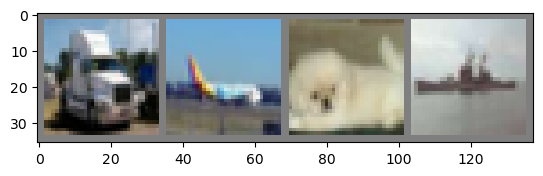

truck plane   dog  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Defining a Neural Network

In [5]:
# Define Resnet using default weights
net_1 = torchvision.models.resnet50(weights = "DEFAULT")
net_1.name = "resnet50"

# Set the model to run on the device
net_1 = net_1.to(device)

In [6]:
# Define Densenet using default weights
net_2 = torchvision.models.densenet121(weights = "DEFAULT")
net_2.name = "densenet121"

# Set the model to run on the device
net_2 = net_2.to(device)

## Training Model

In [ ]:
import torch.optim as optim

# Configuration

model = net_1
learning_rate = 0.01
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Initialize the run with configs above on WandB
run = wandb.init(project="cifar10-project", 
                 config={"batch_size": batch_size,
                         "learning_rate": learning_rate,
                         "momentum": momentum,
                         "model": model.name} )

# Training
for epoch in range(10):  # loop over the dataset
    
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # Use those GPUs!
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = 100 * correct // total

        # Print statistics
        running_loss += loss.item()
        
        if i % 200 == 199:    # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    wandb.log({'epoch': epoch, 'accuracy': train_acc, 'loss': loss.item()})

    print('Finished Training')

wandb: Currently logged in as: ekin. Use `wandb login --relogin` to force relogin


[1,   200] loss: 3.199
[1,   400] loss: 2.151
[1,   600] loss: 2.028
[1,   800] loss: 1.958
[1,  1000] loss: 1.929
[1,  1200] loss: 1.864
[1,  1400] loss: 1.858
[1,  1600] loss: 1.827
[1,  1800] loss: 1.751
[1,  2000] loss: 1.704
[1,  2200] loss: 1.677
[1,  2400] loss: 1.677


In [42]:
# Testing the performance of the model on test set
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %
